# Topic Modeling

As with other forms of natural language processing, *topic modeling* allows us to quickly and systematically analyze vast quantities of unstructured text. With topic modelling, we are able to uncover some of the more abstract, underlying themes contained within large collections of text without the need to assign pre-determined categories or tags to the corpus. 

This lesson will go over what, exactly, topic modeling does, walk through how to run Latent Dirichlet allocation (LDA) topic models in Python, and introduce a number of fit statistics to help us better understand the topic models we'll be generating. We'll end with a discussion of several useful visualization tools for topic modeling. 

# What is Topic Modeling?


As a form of unsupervised machine learning, *topic modeling* allows for the classification of large collections of textual documents into natural groups, without the need for extensive human supervision. Employed in text mining and natural language processing, topic models can uncover the hidden, or *latent*, meanings of language patterns within texts.  

[Source](https://www.tidytextmining.com/topicmodeling.html)


## Setup

In addition to `matplotlib inline` and `pandas`, we'll also be importing `CountVectorizer` from [scikit-learn](https://scikit-learn.org/stable/), a machine learning library for Python. For more information on the usage and relavent parameters taken by `CountVectorizer`, see the chapter on Text Classification. 

We'll also want to use `pandas` to increase our maximum column width to 120 characters, over the default 50-character column width. This will help us more easily glance over text in the dataframe. 



In [1]:
%matplotlib inline

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer


pd.set_option('display.max_colwidth', 120)

In this chapter we'll be looking at [transcriptions](https://www.kaggle.com/unitednations/un-general-debates) of United Nations General Debates, from 1980 to 1999. We've previously looked at the same dataset when disucssing word frequencies. 

In [2]:
un_df = pd.read_json('un-general-debates.json')
print(len(un_df))

3214


With 3,214 complete transcriptions of UN members' statements to work with, this is an ideal dataset to use as we begin playing around with topic models. 

Let's look at a small random sample of 5 texts from the dataframe to get a feel for what we're dealing with:

In [3]:
un_df.sample(5)

,index,speech_year,country_code,speech_text
370,825,1991,EST,﻿I extend my warm congratulations to Mr. Shihabi on his election to the presidency of the General Assembly at its fo...
1336,2630,1995,COL,On behalf of my Government I congratulate\nMr. Freitas do Amaral of Portugal on his election to the\npresidency of t...
504,959,1986,LKA,"It gives me great pleasure to see you. Sir, a distinguished son of South Asia, presiding ever this forty-first sessi..."
2311,4758,1980,MRT,"﻿We are pleased to extend to you, Mr. President, at the very outset of our statement the congratulations of the dele..."
2610,5907,1981,SLV,"2.\t Mr. President, I should like to congratulate you on your election to the presidency of the thirty-sixth session..."


### Topic Modeling Exercise 1


Take a look at the text of the UN speeches. When delivering an address, what are the different topics that are covered? Make a list of four topics and provide three example words from each topic.




![](images/lda.jpg)

## Latent Dirichlet allocation (LDA) 

We'll narrow our focus for the time being to one particular form of topic modeling, *Latent Dirichlet allocation*, or *LDA* for short. With LDA topic modeling, we'll be able to treat every document in our corpus as a mixture of topics. Each document in our corpus can contain words associated with any number of topics in varying proportions. At the same time, each topic can be treated as a mixture of words. Any given word can be associated with any number of topics. Considering our documents and topics as these sorts of "mixtures" helps us to mimic the thematic subtleties inherent in natural language.

[Source](https://www.tidytextmining.com/topicmodeling.html#latent-dirichlet-allocation)

![](images/lda.jpg)

We can import `LatentDirichletAllocation` from scikit-learn to run our own LDA topic models in Python. 

In [4]:
from sklearn.decomposition import LatentDirichletAllocation

### Converting Documents to Vectors

In order to run our topic models, we'll need to convert each document in the corpus into a fixed-length vector of token counts. We can accomplish this using the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html?highlight=vectorizer#sklearn.feature_extraction.text.CountVectorizer) function we imported earlier in the chapter.


For now, let's set our parameters so that we convert all text to lower case, only look at unigrams, only look at terms with a document frequency of .90 or below, use the default 'english' stopwords list, and only consider the top 1,000 terms in our corpus.  

In [5]:
vectorizer = CountVectorizer(lowercase   = True,
                             ngram_range = (1,1),
                             max_df      = .90,
                             stop_words   = 'english',
                             max_features = 1000)

After setting our parameters, we can `fit` the vectorizer to the `speech_text` key in our UN General Debate dataframe to build a vocabulary out of the raw documents.

*Note*: You'll run into an Attribute Error if the key you plan to fit the vectorizer to contains any missing values. While we don't have to worry about this with our UN dataframe, if you encounter such an error in the future, be sure to [clean your dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#missing-data) before attempting to fit the vectorizer. 

In [6]:
vectorizer.fit(un_df['speech_text'])

CountVectorizer(max_df=0.9, max_features=1000, stop_words='english')

We can use the `len` function, along with `get_feature_names`, to ensure we're dealing with a vocabulary composed of the top 1,000 highest-frequency terms in our corpus. 

In [7]:
len(vectorizer.get_feature_names())

1000

Now we'll want to use the vectorizor to `transform` the raw documents into a document-term matrix. 

In [8]:
un_word_counts = vectorizer.transform(un_df['speech_text'])

### Running the LDA Model

Now that we've vectorized our dataset, we're just about ready to run our first LDA model in Python. Before we do, though, we'll want to set our parameters. Below is some information on the parameters we'll set. 

#### `LatentDirichletAllocation` Parameters

- **n_components**: Sets the number of topics generated. We can set this as high or as low as we like, depending on the size and character of the texts in our corpus. 


- **max_iter**: Sets the maximum number of iterations. By default, `max_iter` is set to 10.
> - ***Note***: In almost every case, we'll want to set `max_iter` above 10. It's highly unlikely our models will converge in 10 iterations or less. In the following example, we'll set `max_iter` to 50, a more reasonable maximum iteration threshold.

- **evaluate_every**: Lets us adjust how frequently we gauge the perplexity of our model across iterations. By default, `evaluate_every` is set to 0.
> - ***Note***: Leaving `evaluate_every` at 0 leaves our model without any built-in goodness of fit measure. We'll discuss other measurements of model fit later in the chapter, but for now it's useful to set `evaluate_every` to some positive number. In the following example, we'll `evaluate_every` 5 iterations.

- **n_jobs**: Sets the number of concurrently running processes. When set to -1, we'll use all processors. To use all processors but one, set `n_jobs` to -2. 


- **verbose**: Lets us determine whether or not every step of the process is logged. If > 0, we'll be able to see what's going on with our LDA model through the output in real time. 

In [9]:
lda_model = LatentDirichletAllocation(n_components = 10,
                                      max_iter     = 50,
                                      evaluate_every = 5,
                                      n_jobs       = -1,
                                      verbose      = 1)

With our parameters set, we can `fit` the LDA model to our document-term matrix of the UN General Debate transcripts.

*Note*: It's going to take a while to work our way through up to 50 iterations. That's alright.

In [10]:
lda_model.fit(un_word_counts)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50, perplexity: 711.0737
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50, perplexity: 704.3359
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50, perplexity: 702.4462
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50, perplexity: 701.4847
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50, perplexity: 700.7602
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50

LatentDirichletAllocation(evaluate_every=5, max_iter=50, n_jobs=-1, verbose=1)

Congrats, you've run your first topic model on Python!

## Some fit statistics

While we can intuitively "eyeball" topic quality as a first step, it's hard to do so objectively.  Calculating some fit statistics can help us to evaluate our topics' quality numerically.


`LatentDirichletAllocation` includes a few handy methods for calculating fit statistics:

- **`score()`** lets us calculate the approximate logged likelihood of the model parameters we've set, given our data. The higher this number is, the better our topic fit. 
- **`perplexity()`**, another (normalized) form of logged likelihood, calculates the amount of "surprise" our model experiences if we introduce some previously unseen data. The lower this number is, the better our topic fit.

To learn more about evaluating fit for LDA topic models in Python, see [here](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

In [11]:
print("Log Likelihood: ", lda_model.score(un_word_counts))

print("Perplexity: ", lda_model.perplexity(un_word_counts))

Log Likelihood:  -17539022.088006437
Perplexity:  699.3729778593845


### Guidelines on topic fit
1. Low perplexity on test data.
    - Remeber that the lower our perplexity score, the better our topic fit to our data.
2. Topical coherence
    - On the other hand, we want our models to receive the highest possible scores for topical coherence. 
3. Best fit in a classification task.
    - We'll discuss classification tasks in more detail in another chapter. These tasks provide an additional means of determining our models' goodness of fit.
4. Extract more and then bin them yourself. 
    - It's also possible to just extract more topic models, and use your human intuition to bin them based on contextual or thematic similarity. 

In [12]:
print(lda_model.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': 5, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 50, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 1}


## Visualizing Topics

In this section we'll discuss some of the ways we can visualize the topics we've created with our LDA model. 

### pdtext

First, we can import `topic_words` from the `pdtext` package in order to create a easily interpretable matrix of our topics. Below, we'll look at the first 10:

In [13]:
from pdtext.tm import topic_words

topic_words(lda_model, vectorizer).head(10)


,1,2,3,4,5,6,7,8,9,10
Topic 1,war,today,democracy,freedom,history,rights,power,america,future,life
Topic 2,rights,council,european,europe,member,important,conflict,keeping,role,cooperation
Topic 3,arab,israel,council,iraq,palestinian,region,resolutions,lebanon,israeli,middle
Topic 4,peoples,relations,respect,problems,order,rights,situation,social,principles,operation
Topic 5,independence,republic,peoples,south,military,struggle,national,afghanistan,foreign,aggression
Topic 6,global,nuclear,cooperation,developing,council,reform,social,year,trade,member
Topic 7,south,developing,operation,africa,problems,year,conference,problem,hope,negotiations
Topic 8,africa,african,south,situation,angola,oau,apartheid,continent,namibia,debt
Topic 9,republic,national,democratic,process,cooperation,social,democracy,mr,order,like
Topic 10,nuclear,weapons,soviet,disarmament,arms,union,treaty,republic,relations,war


Also from `pdtext`, `topic_pred` will let us see which documents are associated with which topics.

In [14]:
from pdtext.tm import topic_pred

In [15]:
un_topics = topic_pred(lda_model, un_word_counts, vectorizer)

In [16]:
un_topics

,war_today_democracy,rights_council_european,arab_israel_council,peoples_relations_respect,independence_republic_peoples,global_nuclear_cooperation,south_developing_operation,africa_african_south,republic_national_democratic,nuclear_weapons_soviet
0,0.040357,0.000127,0.093730,0.027321,0.000127,0.144233,0.601009,0.000127,0.057900,0.035069
1,0.000135,0.367703,0.000135,0.043572,0.000135,0.260831,0.327087,0.000135,0.000135,0.000135
2,0.050124,0.000077,0.054319,0.245699,0.035003,0.030415,0.092843,0.314829,0.106998,0.069694
3,0.334264,0.000147,0.022080,0.380081,0.000147,0.000147,0.193770,0.000147,0.069071,0.000147
4,0.110692,0.100106,0.000089,0.010880,0.068794,0.000089,0.329126,0.339845,0.016699,0.023680
...,...,...,...,...,...,...,...,...,...,...
3209,0.166190,0.653301,0.055427,0.000270,0.000270,0.123465,0.000270,0.000270,0.000270,0.000270
3210,0.000097,0.081100,0.588464,0.000097,0.000097,0.077890,0.089049,0.000097,0.163009,0.000097
3211,0.000204,0.000204,0.000204,0.103161,0.000204,0.087980,0.006548,0.168781,0.632510,0.000204
3212,0.374651,0.000121,0.000121,0.270315,0.000121,0.301063,0.000121,0.000121,0.053244,0.000121


We can now use our topics as features in order to get a better handle on topic patterns across texts.

One way to do this is to generate a new key in our United Nations dataframe. For exmaple, we can create a `post_soviet` key to divide our general debate speeches between those that occured prior to the fall of the Soviet Union (where `post_soviet` = False), and those that occured after the fall of the Soviet Union (where `post_soviet` = True).

In [17]:
un_df['post_soviet'] = un_df['speech_year'] > 1991

In [18]:
un_topics.groupby(un_df['post_soviet']).mean()

,war_today_democracy,rights_council_european,arab_israel_council,peoples_relations_respect,independence_republic_peoples,global_nuclear_cooperation,south_developing_operation,africa_african_south,republic_national_democratic,nuclear_weapons_soviet
post_soviet,,,,,,,,,,
False,0.11912,0.058009,0.083061,0.169419,0.090727,0.046458,0.216314,0.090824,0.043156,0.082912
True,0.12459,0.156116,0.054513,0.079830,0.022925,0.271077,0.027100,0.054382,0.180922,0.028545


In [19]:
un_topics.groupby(un_df['post_soviet']).mean().T

post_soviet,False,True
war_today_democracy,0.119120,0.124590
rights_council_european,0.058009,0.156116
arab_israel_council,0.083061,0.054513
peoples_relations_respect,0.169419,0.079830
independence_republic_peoples,0.090727,0.022925
global_nuclear_cooperation,0.046458,0.271077
south_developing_operation,0.216314,0.027100
africa_african_south,0.090824,0.054382
republic_national_democratic,0.043156,0.180922
nuclear_weapons_soviet,0.082912,0.028545


### pyLDAvis

The [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html) library, a port of the [LDAvis](https://github.com/cpsievert/LDAvis) package for R, provides a variety of tools for interactive topic model visualization. 

In [20]:
pip install pyldavis

`pyLDAvis` is conveniently compatible with `LatentDirichletAllocation` from scikit-learn.

In [21]:
import pyLDAvis
import pyLDAvis.sklearn

We'll also import `pyplot` from matplotlib to allow for the generation of interactive plots in Python. 

In [22]:
import matplotlib.pyplot as plt

Now we'll want to use the `enable_notebook()` function to allow us to display visualizations in our notebook.

In [23]:
pyLDAvis.enable_notebook()

Finally, we can use the `prepare()` function to transform the data from our LDA model into interactive visualizations!

In [24]:
pyLDAvis.display(pyLDAvis.sklearn.prepare(lda_model, un_word_counts, vectorizer, mds='tsne'))

### Topic Modeling Exercise 2

In your group, do 1 and 2 in 10_Topic_Modeling_group



#### Text Classification and Sentiment Analysis 

We'll be using the following to apply classify texts and analyze sentiment within our corpus:
- [seaborn](https://seaborn.pydata.org/), a data visualization library based on `matplotlib`. `seaborn` is also discussed in a previous chapter on text classification
- The `SentimentIntensityAnalyzer` available through [vaderSentiment](https://github.com/cjhutto/vaderSentiment), a lexicon for sentiment analysis discussed in the previous chapter on Word Lists and Sentiment Analysis. With this, we'll be able to determine the intensity of positive, negative, and neutral sentiments contained within the documents in our corpus.
- [Afinn](https://pypi.org/project/afinn/), another sentiment analysis tool discussed in the previous chapter on Word Lists and Sentiment Analysis. `Afinn` will produce a single numerical sentiment score, from -5 (negative sentiment) to 5 (positive sentiment).

In [26]:
%matplotlib inline

import pandas as pd
import seaborn as sns

In [27]:
pip install afinn

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install vaderSentiment

In [31]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn

In addition to `Afinn` and the `SentimentIntensityAnalyzer`, we'll also import a number of new functions from `sklearn`.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

First among these imported functions is [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression), scikit-learn's logicstic regression classifier. While we've used `LogisticRegression` earlier in the chapter on Classification, at that point we didn't specify any parameters. In this exercise, we'll specify two:

- **solver**: In the following example we'll be setting this to `lbfgs`, or [Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm](http://aria42.com/blog/2014/12/understanding-lbfgs). If not otherwise specified, `solver` will default to `lbfgs`. There are a number of other solvers available, discussed in more detail in the `LogisticRegression`[User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).


- **max_iter**: Similar to what we saw earlier with `LatentDirichletAllocation`, here `max_iter` allows us to set a maximum threshold on the number of iterations in our regression before the solvers converge. 

We'll set the maximum iterations in our own `lr_classifier` to 5,000.

In [30]:
lr_classifier = LogisticRegression(solver = 'lbfgs', max_iter= 5000)


Let's `fit` the model to our data based on the `post_soviet` key we've created. 

In [31]:
lr_classifier.fit(un_topics, un_df['post_soviet'])

LogisticRegression(max_iter=5000)

Our classifier can now be used to `predict` an accuracy score for our topics.

In [32]:
prediction = lr_classifier.predict(un_topics)

In [33]:
print(accuracy_score(un_df['post_soviet'], prediction))



0.940883634100809


We're also now able to produce a classification report:

In [34]:
print(classification_report(un_df['post_soviet'], prediction))

              precision    recall  f1-score   support

       False       0.96      0.94      0.95      1803
        True       0.92      0.94      0.93      1411

    accuracy                           0.94      3214
   macro avg       0.94      0.94      0.94      3214
weighted avg       0.94      0.94      0.94      3214



Finally, we can use `seaborn` to generate a confusion matrix using the `heatmap` function. 

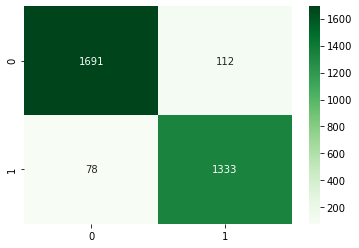

In [35]:
import seaborn as sns

cm = confusion_matrix(un_df['post_soviet'], prediction)
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')

### Topic Modeling Exercise 3



Hopefully, you feel a bit more comfortable running LDA models in Python. In the next chapter, we'll be moving beyond LDA models to cover addtional forms of topic modeling. 

#### References:

Finn Årup Nielsen. 2011. “A New ANEW: Evaluation of a Word List for Sentiment Analysis in Microblogs.” *Proceedings of the ESWC2011 Workshop on ‘Making Sense of Microposts’: Big Things Come in Small Packages.* Volume 718 in CEUR Workshop Proceedings: 93-98. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors).

Hutto, C.J. and Eric Gilbert. 2014. VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

Sievert, Carson and Kenneth Shirley. 2014. "LDAvis: A Method for Visualizing and Interpreting Topics." In *Proceedings of the Workshop on Interactive Language Learning, Visualization, and Interfaces*, pp. 63-70. 

Silge, Julia. and David Robinson. 2017. *Text Mining with R: A Tidy Approach.* "O'Reilly Media, Inc.".